In [1]:
import h5py
import gc_utils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
simulation = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"

proc_file = sim_dir + simulation + "/" + simulation + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

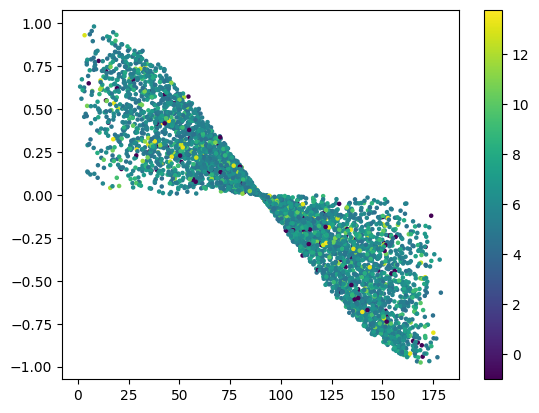

In [3]:
snap = 214
snap_id = gc_utils.snapshot_name(snap)

gc_id_snap = proc_data["it000"]["snapshots"][snap_id]["gc_id"][()]

ana_flag = proc_data["it000"]["source"]["analyse_flag"][()] == 1
gc_id_sour = proc_data["it000"]["source"]["gc_id"][ana_flag]
t_dis = proc_data["it000"]["source"]["t_dis"][ana_flag]

t_dis_lst = []
for gc in gc_id_snap:
    idx = np.where(gc_id_sour == gc)[0][0]
    t_dis_lst.append(t_dis[idx])

acc_mask = proc_data["it000"]["snapshots"][snap_id]["acc_snap"][()] <= snap
x = proc_data["it000"]["snapshots"][snap_id]["inc"][acc_mask]
y = proc_data["it000"]["snapshots"][snap_id]["lz_norm"][acc_mask]
c = np.array(t_dis_lst)[acc_mask]

plt.scatter(x, y, c=c, s=5)
# plt.xscale("log")
plt.colorbar()

In [4]:
proc_data["it000"]["source"].keys()

<KeysViewHDF5 ['accretion_flag', 'analyse_flag', 'feh', 'form_lbt', 'form_time', 'gc_id', 'group_id', 'halo_acc_cid', 'halo_acc_tid', 'halo_pre_acc_cid', 'halo_pre_acc_tid', 'halo_z0', 'halo_zform', 'is_mpb', 'last_snap', 'logm_tform', 'logm_z0', 'ptype', 'pubsnap_zform', 'quality', 'real_flag', 'snap_acc', 'snap_pre_acc', 'snap_zform', 'survive_flag', 'survived_accretion', 't_acc', 't_dis', 'zform']>

In [5]:
proc_data["it000"]["snapshots"][snap_id].keys()

<KeysViewHDF5 ['acc_snap', 'bound_flag', 'ecc', 'ek', 'ep_agama', 'ep_fire', 'et', 'et_norm', 'gc_id', 'group_id', 'halo.pos.cyl', 'halo.pos.xyz', 'halo.r', 'halo.vel.cyl', 'halo.vel.xyz', 'halo_zform', 'inc', 'j.cyl', 'jphi', 'jr', 'jz', 'l.xyz', 'lz_norm', 'mass', 'now_accreted', 'pos.cyl', 'pos.xyz', 'ptype', 'r', 'r_apo', 'r_per', 'snap_part_idx', 'survived_accretion', 'vel.cyl', 'vel.xyz']>

In [6]:
proc_data["it000"]["snapshots"][snap_id]["now_accreted"][()]

array([1, 1, 1, ..., 0, 0, 0])

In [7]:
it = 0
snap = 214

it_id = gc_utils.iteration_name(it)
snap_id = gc_utils.snapshot_name(snap)

props = ["inc", "lz_norm", "r", "form_time", "ecc", "logm_tform"]
prop_locs = ["snap", "snap", "snap", "sour", "snap", "sour"]
prop_scale = ["linear", "linear", "log", "linear", "linear", "linear"]

prop_dict = {}

sour_dat = proc_data[it_id]["source"]
sour_ana_mask = sour_dat["analyse_flag"][()] == 1

snap_dat = proc_data[it_id]["snapshots"][snap_id]
snap_acc_mask = snap_dat["now_accreted"][()] == 1

gcid_snap = snap_dat["gc_id"][snap_acc_mask]

prop_dict["gcid"] = gcid_snap

for prop, prop_loc in zip(props, prop_locs):
    if prop_loc == "sour":
        prop_lst = []
        for gcid in prop_dict["gcid"]:
            gcid_idx = np.where(sour_dat["gc_id"][sour_ana_mask] == gcid)[0][0]
            prop_lst.append(sour_dat[prop][gcid_idx])

        prop_dict[prop] = np.array(prop_lst)

    else:
        prop_dict[prop] = snap_dat[prop][snap_acc_mask]

type_lst = []
t_dis_lst = []
group_lst = []
gc_idx_lst = []
for gcid in prop_dict["gcid"]:
    gcid_idx = np.where(sour_dat["gc_id"][sour_ana_mask] == gcid)[0][0]
    t_dis_i = sour_dat["t_dis"][gcid_idx]
    group = np.abs(sour_dat["group_id"][gcid_idx])

    t_dis_lst.append(t_dis_i)
    group_lst.append(group)
    gc_idx_lst.append(gcid_idx)

    if group == 0:
        if t_dis_i < 0:
            type_lst.append("insitu_s")
        else:
            type_lst.append("insitu_d")

    else:
        if t_dis_i < 0:
            type_lst.append("exsitu_s")
        else:
            type_lst.append("exsitu_d")

prop_dict["type"] = np.array(type_lst)

In [26]:
src_mask_0 = sour_dat["group_id"][()] != 1
src_mask_1 = sour_dat["t_dis"][()] < 0
src_mask_2 = sour_dat["analyse_flag"][()] == 1

len(sour_dat["gc_id"][src_mask_0 & src_mask_1 & src_mask_2])

216

In [29]:
t_dis_arr = np.array(t_dis_lst)
len(t_dis_arr[t_dis_arr < 0])

746

In [9]:
i_s = 0
i_d = 0
e_s = 0
e_d = 0

for gc_type in prop_dict["type"]:
    if gc_type == "insitu_s":
        i_s += 1
    elif gc_type == "insitu_d":
        i_d += 1
    elif gc_type == "exsitu_s":
        e_s += 1
    else:
        e_d += 1

In [10]:
i_s, i_d, e_s, e_d

(79, 3947, 667, 66)

In [11]:
grp_mask = proc_data[it_id]["source"]["group_id"][()] != 0
t_dis_mask = proc_data[it_id]["source"]["t_dis"][()] < 0
ana_mask = proc_data[it_id]["source"]["analyse_flag"][()] == 1

len(proc_data[it_id]["source"]["gc_id"][grp_mask & t_dis_mask & ana_mask])

77

In [12]:
pub = sour_dat["t_dis"][sour_ana_mask]
len(pub[pub < 0])

216

In [13]:
len(gcid_snap)

4759

In [14]:
plot_dict = {"insitu_s": {}, "insitu_d": {}, "exsitu_s": {}, "exsitu_d": {}}

for gc_type in plot_dict.keys():
    type_mask = prop_dict["type"] == gc_type
    for prop in props:
        plot_dict[gc_type][prop] = prop_dict[prop][type_mask]


In [15]:
prop_dict["type"]

array(['insitu_d', 'exsitu_s', 'exsitu_s', ..., 'exsitu_d', 'exsitu_d',
       'exsitu_d'], dtype='<U8')

In [16]:
len(plot_dict["exsitu_s"][prop])

667

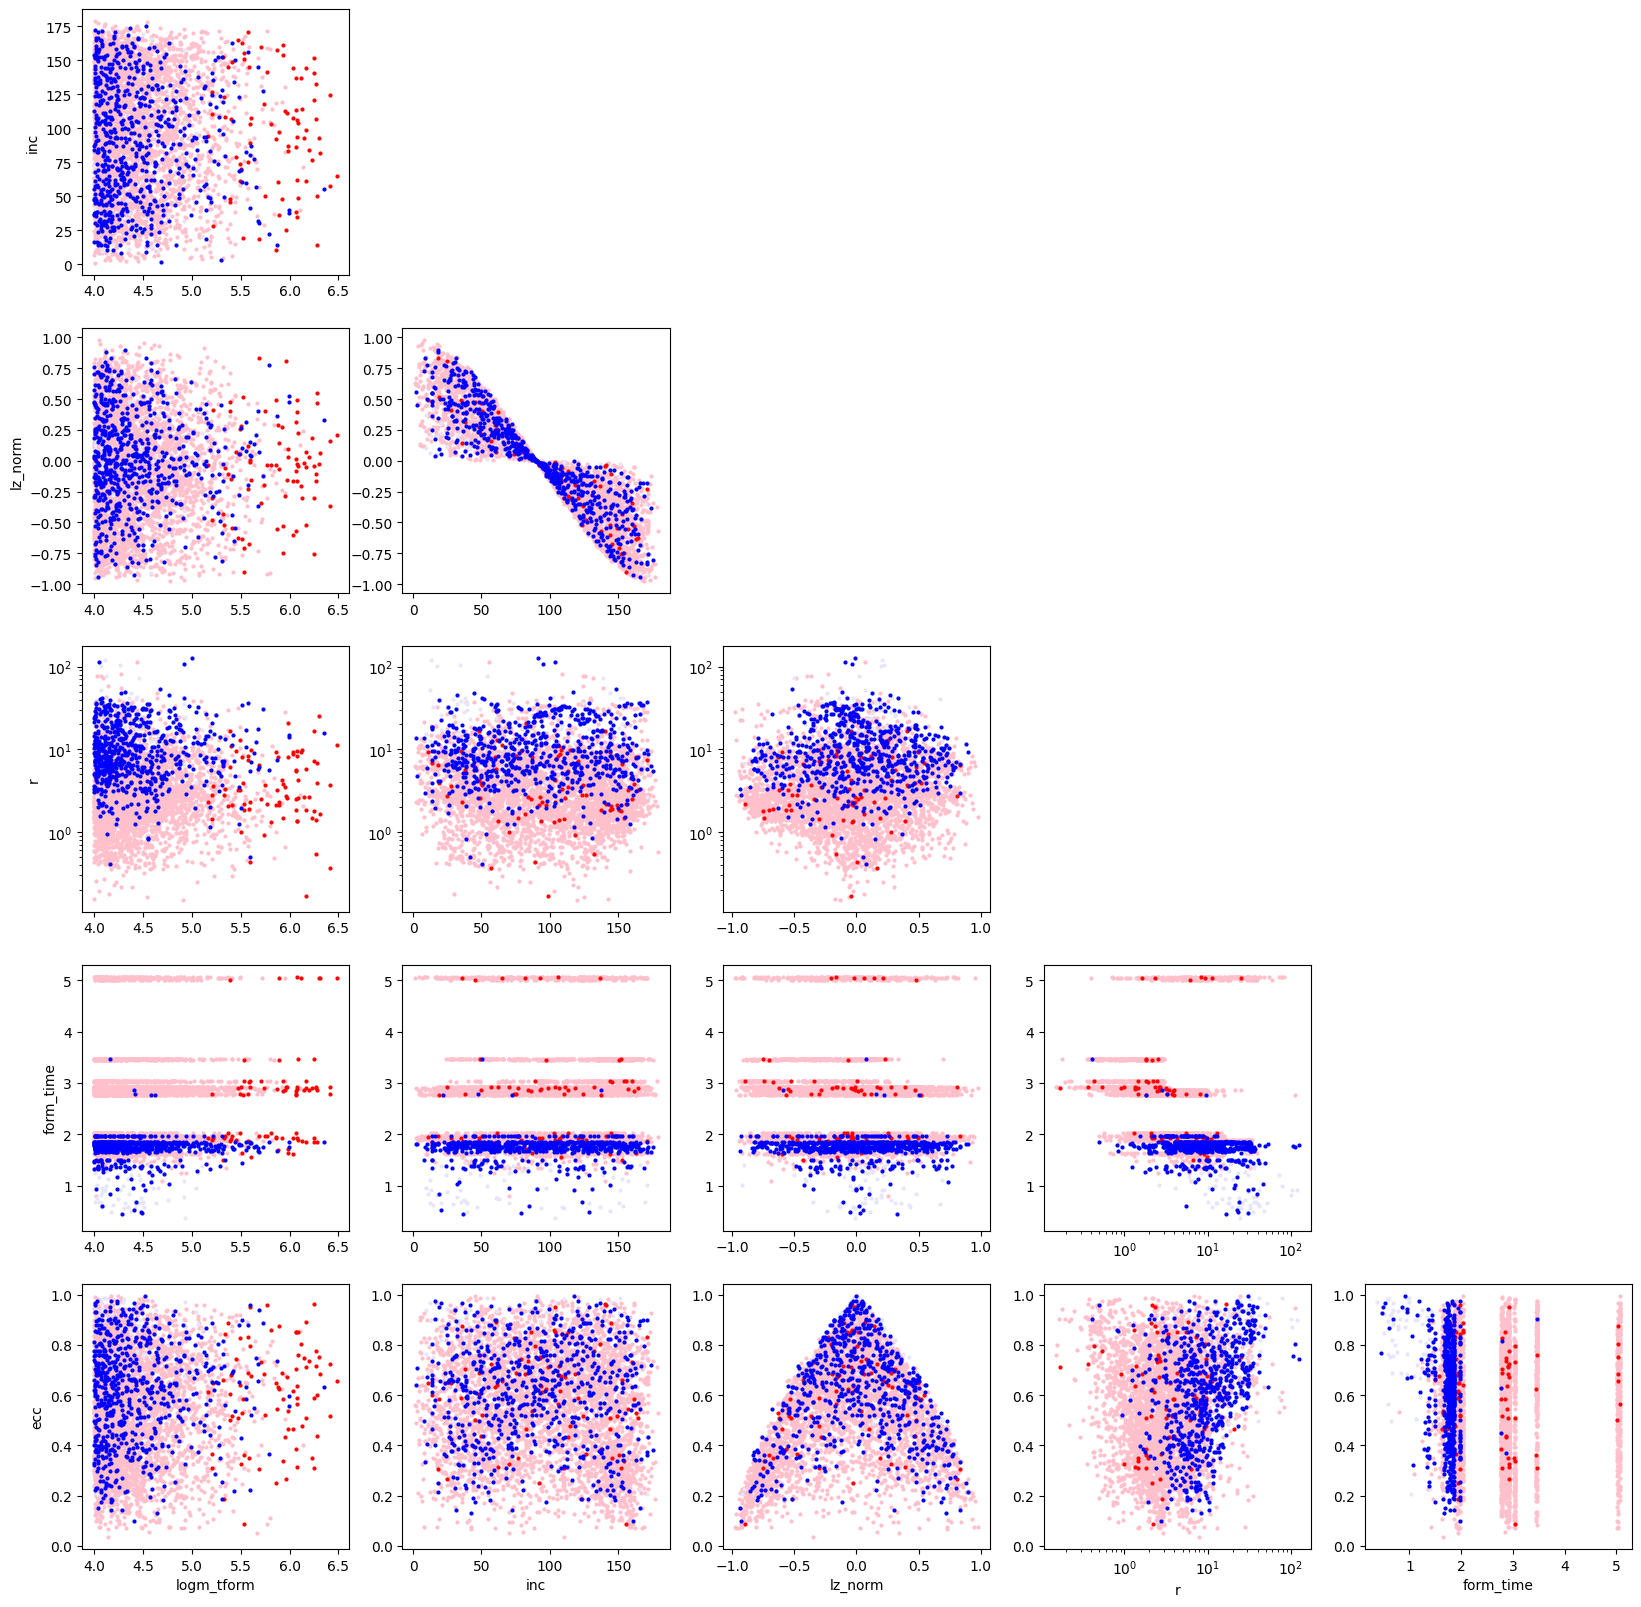

In [17]:
num_rows = len(props) - 1
num_cols = len(props) - 1

plot_c = ["r", "pink", "b", "lavender"]
plot_m = [".", ".", ".", "."]
plot_s = [4, 4, 4, 4]
plot_z = [1, 0, 1, 0]

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# for i, ax in enumerate(axs.flat):
for (i, j), ax in np.ndenumerate(axs):
    if j > i:
        ax.axis("off")

    else:
        prop_x = props[j - 1]
        x_scale = prop_scale[j - 1]

        prop_y = props[i]
        y_scale = prop_scale[i]

        for type_i, gc_type in enumerate(plot_dict.keys()):
            x = plot_dict[gc_type][prop_x]
            y = plot_dict[gc_type][prop_y]

            ax.scatter(x, y, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
            ax.set_xscale(x_scale)
            ax.set_yscale(y_scale)

        if i == num_rows - 1:
            ax.set_xlabel(prop_x)

        if j == 0:
            ax.set_ylabel(prop_y)
